In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import re
import processing as proc
model = SentenceTransformer('all-mpnet-base-v2')

/home/marcuswrrn/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [140]:
df = pd.read_json("./Data_Processing/Data/job_processed_data_main.json")

df.head(20)

: 

: 

In [86]:
# df_testing = df.head(100)

# neutral = df_testing["Neutral_Terminated_Encodings"].tolist()
# titles = df_testing["Job_Titles"]
# time = np.arange(len(neutral[0]))

# for i in range(50):
#     plt.plot(time, neutral[i], label=titles[i])
#     plt.legend()
#     plt.show()

In [3]:
def pooling(encodings):
    # Ensure that all elements in encodings are lists or arrays containing numbers
    if not all(isinstance(vec, (list, np.ndarray)) and all(isinstance(x, (int, float)) for x in vec) for vec in encodings):
        raise ValueError("All elements in 'encodings' should be lists or arrays containing numbers (int or float)")
    encs = np.array([enc for enc in encodings])
    # Compute the mean along axis 0 (columns) and convert the result back to a list
    return np.mean(encs, axis=0)

def find_invalid_rows(df):
    invalid_rows = []

    for index, row in df.iterrows():
        encodings = row["Neutral_Encodings"]

        # Check if encodings is a list or a NumPy array containing numbers (integers or floats)
        if not (isinstance(encodings, (list, np.ndarray)) and all(isinstance(x, (int, float)) for x in encodings)):
            invalid_rows.append(index)

    return invalid_rows

print("Pooling Neutral")
neutral_terminated_pooled = pooling(df["Neutral_Encodings"])
print("Pooling Neutral Terminated")
neutral_pooled_terminated = pooling(df["Neutral_Terminated_Encodings"])
print("Pooling Negative")
negative_pooled = pooling(df["Negative_Encodings"])
print("Pooling Positive")
positive_pooled = pooling(df["Positive_Encodings"])
print("Pooling Positive Leading")
positive_pooled_leading = pooling(df["Positive_Leading_Encodings"])
print("Pooling Negative Leading")
negative_pooled_leading = pooling(df["Negative_Leading_Encodings"])


Pooling Neutral
Pooling Neutral Terminated
Pooling Negative
Pooling Positive
Pooling Positive Leading
Pooling Negative Leading


In [4]:
data = {
    "neutral": neutral_terminated_pooled.tolist(),
    "neutral_terminated": neutral_pooled_terminated.tolist(),
    "positive": positive_pooled.tolist(),
    "positive_leading": positive_pooled_leading.tolist(),
    "negative": negative_pooled.tolist(),
    "negative_leading": negative_pooled_leading.tolist()
}

with open("./Data_Processing/Data/job_pooled_embeddings.json", 'w') as f:
    json.dump(data, f)


In [139]:
df = pd.read_json("./Data_Processing/Data/job_pooled_embeddings.json")

anchor_sent = "I am very happy."
anchor_sent2 = "I am not worth much"
anchor_enc = model.encode(anchor_sent)
anchor_enc2 = model.encode(anchor_sent2)
# cast all values to float
positive_pooled = [float(x) for x in df["positive"]]
negative_pooled = [float(x) for x in df["negative"]]
positive_pooled_leading = [float(x) for x in df["positive_leading"]]
negative_pooled_leading = [float(x) for x in df["negative_leading"]]


pos = positive_pooled 
pos = [float(x) for x in pos]

neg = negative_pooled 
neg = [float(x) for x in neg]

neutral_terminated_pooled = [float(x) for x in df["neutral_terminated"]]
neutral_pooled = [float(x) for x in df["neutral"]]
print(f"Sentence: {anchor_sent2}\n")
print(f"Positive: {util.cos_sim(anchor_enc2, positive_pooled)[0][0]}")
#print(f"Positive Leading: {util.cos_sim(anchor_enc2, positive_pooled_leading)[0][0]}")
print(f"Average Distance: {np.mean(np.abs(anchor_enc2 - positive_pooled))}")
print("==================================================================================")
print(f"Negative: {util.cos_sim(anchor_enc2, negative_pooled)[0][0]}")
#print(f"Negative Leading: {util.cos_sim(anchor_enc2, negative_pooled_leading)[0][0]}")
print(f"Average Distance: {np.mean(np.abs(anchor_enc2 - negative_pooled))}")
#print(f"Neutral: {util.cos_sim(anchor_enc2, neutral_pooled)[0][0]}")
# print(f"Neutral Terminated: {util.cos_sim(anchor_enc, neutral_terminated_pooled)[0][0]}")

Sentence: I am not worth much

Positive: 0.24254858493804932
Average Distance: 0.029253050974587035
Negative: 0.33415910601615906
Average Distance: 0.02692471355647517


In [5]:
print("Neutral")

print(f"Positive: {util.cos_sim(neutral_pooled, positive_pooled)[0][0]}")
print(f"Negative: {util.cos_sim(neutral_pooled, negative_pooled)[0][0]}")
print(f"Positive Leading: {util.cos_sim(neutral_pooled, positive_pooled_leading)[0][0]}")
print(f"Negative Leading: {util.cos_sim(neutral_pooled, negative_pooled_leading)[0][0]}")


print("\nNeutral Terminated")

print(f"Positive: {util.cos_sim(neutral_terminated_pooled, positive_pooled)[0][0]}")
print(f"Negative: {util.cos_sim(neutral_terminated_pooled, negative_pooled)[0][0]}")
print(f"Positive Leading: {util.cos_sim(neutral_terminated_pooled, positive_pooled_leading)[0][0]}")
print(f"Negative Leading: {util.cos_sim(neutral_terminated_pooled, negative_pooled_leading)[0][0]}")

print(f"\nPositive and Negative both Terminated Similarity: {util.cos_sim(positive_pooled, negative_pooled)[0][0]}")
print(f"Positive and Negative both Leading Similarity: {util.cos_sim(positive_pooled_leading, negative_pooled_leading)[0][0]}")
print(f"Positive leading and Negative Terminated: {util.cos_sim(positive_pooled_leading, negative_pooled)[0][0]}")
print(f"Negative Leading and Positive Terminated: {util.cos_sim(positive_pooled, negative_pooled_leading)[0][0]}")

Neutral
Positive: 0.8817288875579834
Negative: 0.7661342620849609
Positive Leading: 0.900155782699585
Negative Leading: 0.7889934778213501

Neutral Terminated
Positive: 0.9184889793395996
Negative: 0.78498375415802
Positive Leading: 0.9108242988586426
Negative Leading: 0.7872662544250488

Positive and Negative both Terminated Similarity: 0.7447354793548584
Positive and Negative both Leading Similarity: 0.8222670555114746
Positive leading and Negative Terminated: 0.7679519653320312
Negative Leading and Positive Terminated: 0.7781923413276672


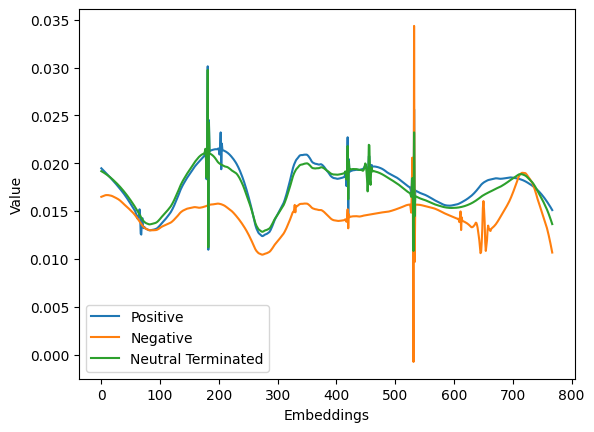

In [6]:
time = np.arange(len(neutral_terminated_pooled))

plt.plot(time, proc.denoise(np.abs(np.array(positive_pooled))), label='Positive')
plt.plot(time, proc.denoise(np.abs(np.array(negative_pooled))), label='Negative')
plt.plot(time, proc.denoise(np.abs(np.array(positive_pooled_leading))), label='Neutral Terminated')

plt.xlabel('Embeddings')
plt.ylabel('Value')

plt.legend(loc='best')
plt.show()

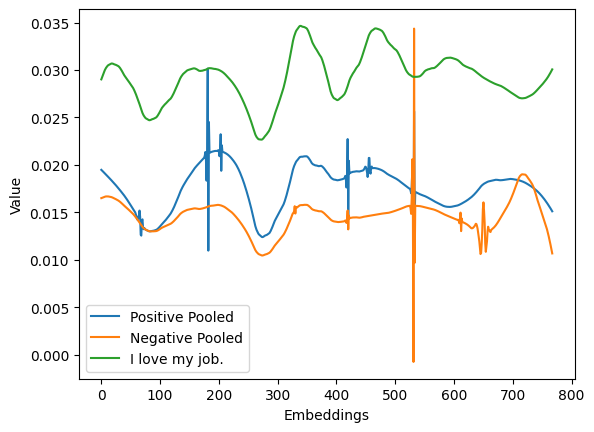

Average Neutral: -9.953051360817756e-05
Average Positive: -0.0001339357838018039
Average Negative: -0.00012091400753124469


In [35]:
anchor_sent = "I love my job."
anchor_enc = model.encode(anchor_sent)
time = np.arange(len(anchor_enc))
plt.plot(time, proc.denoise(np.abs(np.array(positive_pooled))), label='Positive Pooled')
plt.plot(time, proc.denoise(np.abs(np.array(negative_pooled))), label='Negative Pooled')
plt.plot(time, proc.denoise(np.abs(np.array(anchor_enc))), label=anchor_sent)

plt.xlabel('Embeddings')
plt.ylabel('Value')

plt.legend(loc='best')
plt.show()

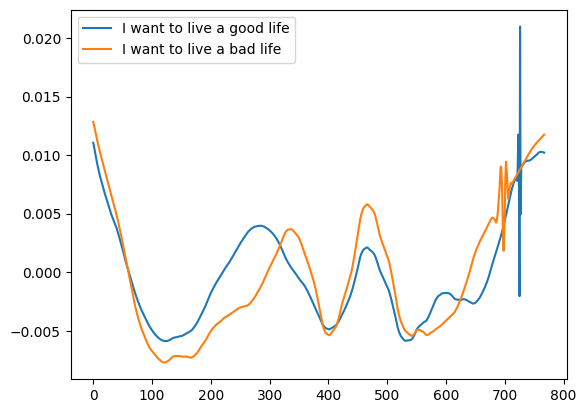

Similarity: 0.726620078086853
Average positive: -0.00022620502568315715
Average negative: -0.000388477899832651


In [32]:
anchor_sent1 = "I want to live a good life"
anchor_enc1 = model.encode(anchor_sent1)
anchor_sent2 = "I want to live a bad life"
anchor_enc2 = model.encode(anchor_sent2)

plt.plot(time, proc.denoise(anchor_enc1), label=anchor_sent1)
plt.plot(time, proc.denoise(anchor_enc2), label=anchor_sent2)
plt.legend()
plt.show()

print(f"Similarity: {util.cos_sim(anchor_enc1, anchor_enc2)[0][0]}")

print(f"Average positive: {np.mean(anchor_enc1)}")
print(f"Average negative: {np.mean(anchor_enc2)}")

In [106]:
# Similarity search

def find_similar_slice(positive, negative, anchor, start_slice=0, end_slice=756):
    pos_slice = positive[start_slice:end_slice]
    neg_slice = negative[start_slice:end_slice]
    anch_slice = anchor[start_slice:end_slice]
    return util.cos_sim(pos_slice, anch_slice)[0][0], util.cos_sim(neg_slice, anch_slice)[0][0]


embed_range = 50

max_pos_sim = 0
pos_index = 0
max_neg_sim = 0
neg_index = 0

for i in range(embed_range, len(anchor_enc), embed_range):
    end_slice = i if i < len(anchor_enc) else len(anchor_enc) -1
    pos_sim, neg_sim = find_similar_slice(positive_pooled, negative_pooled, anchor_enc, start_slice=i-embed_range, end_slice=end_slice)

    if pos_sim >= max_pos_sim:
        max_pos_sim = pos_sim
        pos_index = i
    if neg_sim >= max_neg_sim:
        max_neg_sim = neg_sim
        neg_index = i

print(f"Positive: Similarity {max_pos_sim}, from {pos_index-embed_range} to {pos_index}")
print(f"Negative: Similarity {max_neg_sim}, from {neg_index-embed_range} to {neg_index}")


print(f"Similarity between positive and negative: {util.cos_sim(positive_pooled[pos_index-embed_range:pos_index], negative_pooled[neg_index - embed_range:neg_index])[0][0]}")

Positive: Similarity 0.676430344581604, from 450 to 500
Negative: Similarity 0.6019370555877686, from 300 to 350
Similarity between positive and negative: -0.03637512028217316


In [107]:
s = 150
e = 200
pos_sim, neg_sim = find_similar_slice(positive_pooled, negative_pooled, anchor_enc, s, e)

print(f"Positive: Similarity {pos_sim}")
print(f"Negative: Similarity {neg_sim}")
print(f"Similarity between positive and negative: {util.cos_sim(positive_pooled[s:e], negative_pooled[s:e])[0][0]}")

Positive: Similarity 0.6459465026855469
Negative: Similarity 0.5836480259895325
Similarity between positive and negative: 0.8593383431434631


Got these results for "I have a job."

Positive: Similarity 0.6694032549858093, from 150 to 200
Negative: Similarity 0.6307297945022583, from 150 to 200
Similarity between positive and negative: 0.8593383431434631

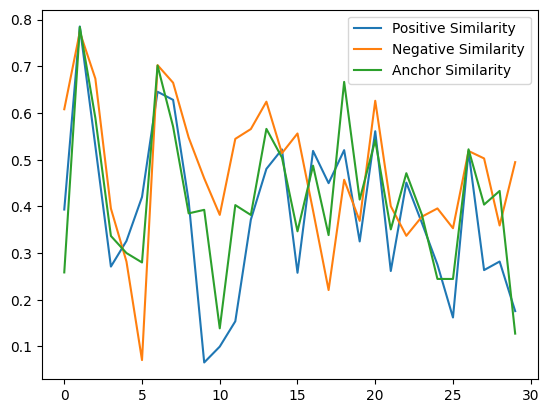

I hate my job.


In [119]:
def cos_sim_graphing(embed1, embed2, embed_range=5):
    sim_scores = []
    for i in range(embed_range, len(embed1), embed_range):
        val = i if i < len(embed1) else len(embed1) -1
        sim_scores.append(util.cos_sim(embed1[val - embed_range:val], embed2[val - embed_range:val])[0][0])
    return sim_scores

positive = cos_sim_graphing(positive_pooled, anchor_enc, 25)
negative = cos_sim_graphing(negative_pooled, anchor_enc, 25)
neutral = cos_sim_graphing(neutral_pooled, anchor_enc, 25)
time = np.arange(len(positive))

plt.plot(time, positive, label="Positive Similarity")
plt.plot(time, negative, label="Negative Similarity")
plt.plot(time, neutral, label="Anchor Similarity")
plt.legend()
plt.show()
print(anchor_sent)

In [109]:
# Need to get lengths of words
def count_words(sent):
    return len(sent.split())


pos_words_count = df["Positive"].apply(lambda x: count_words(x)).tolist()
neg_words_count = df["Negative"].apply(lambda x: count_words(x)).tolist()
neut_words_count = df["Neutral"].apply(lambda x: count_words(x)).tolist()

def calc_avg(counts):
    return np.sum(counts)/len(counts)

num_sents = len(df["Positive"])
print(num_sents)


print(f"Positive: {round(calc_avg(pos_words_count), 2)}")
print(f"Negative: {round(calc_avg(neg_words_count), 2)}")
print(f"Neutral: {round(calc_avg(neut_words_count), 2)}")

KeyError: 'Positive'